<a href="https://colab.research.google.com/github/TheDoctorAI/AI-Trader/blob/master/lstm_forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install ccxt pprint
# -*- coding: utf-8 -*-
import ccxt
from datetime import datetime
import csv
from google.colab import drive
from pprint import pprint
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def write_to_csv(filename, data):
    with open(filename, mode='w') as output_file:
        output_file.write("Date,Open,High,Low,Close,Adj Close,Volume\n")
        csv_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerows(data)

        
def scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    earliest_timestamp = exchange.milliseconds()
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    timedelta = limit * timeframe_duration_in_ms
    all_ohlcv = []
    while True:
        fetch_since = earliest_timestamp - timedelta
        ohlcv = retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        if ohlcv[0][0] >= earliest_timestamp:
            break
        earliest_timestamp = ohlcv[0][0]
        all_ohlcv = ohlcv + all_ohlcv
        print(len(all_ohlcv), 'candles in total from', exchange.iso8601(all_ohlcv[0][0]), 'to', exchange.iso8601(all_ohlcv[-1][0]))
        if fetch_since < since:
            break
    return all_ohlcv


def retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    num_retries = 0
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise

            
def scrape_candles_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    exchange = getattr(ccxt, exchange_id)({
        'enableRateLimit': True,
    })
    if isinstance(since, str):
        since = exchange.parse8601(since)
    exchange.load_markets()
    ohlcv = scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit)
    key = 0
    for candle in ohlcv:
        epoch = int(candle[0]) / 1000
        ohlcv[key][0] = datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d')
        ohlcv[key][5] = int(candle[5])
        ohlcv[key].append(ohlcv[key][5])
        ohlcv[key][5] = ohlcv[key][4]
        key += 1
    ohlen = len(ohlcv)
    pprint("num of candles: "+ str(ohlen))
    if ohlen > 399:
        ohrem = ohlen - 399
        pprint("removing: "+str(ohrem))
        ohlcv = ohlcv[ohrem:]
    write_to_csv(filename, ohlcv)
    print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]), 'to', filename)

In [0]:
exchange = "bitmex"
symbol = "BTC/USD"
start_date = "2018-01-01T00:00:00Z"

timeframe = "1d"
outfile = "/content/gdrive/My Drive/Colab Notebooks/ai-trader/data/btcusd-"+timeframe+".csv"
scrape_candles_to_csv(outfile, exchange, 3, symbol, timeframe, start_date, 100)

100 candles in total from 2019-01-30T00:00:00.000Z to 2019-05-09T00:00:00.000Z
200 candles in total from 2018-10-22T00:00:00.000Z to 2019-05-09T00:00:00.000Z
300 candles in total from 2018-07-14T00:00:00.000Z to 2019-05-09T00:00:00.000Z
400 candles in total from 2018-04-05T00:00:00.000Z to 2019-05-09T00:00:00.000Z
500 candles in total from 2017-12-26T00:00:00.000Z to 2019-05-09T00:00:00.000Z
'num of candles: 500'
'removing: 101'
Saved 399 candles from None to None to /content/gdrive/My Drive/Colab Notebooks/ai-trader/data/btcusd-1d.csv


In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [0]:
df = pd.read_csv(outfile)
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-04-06,6779.0,6935.0,6555.0,6769.5,6769.5,3283289247
1,2018-04-07,6769.5,6875.0,6479.5,6612.0,6612.0,2256699483
2,2018-04-08,6612.0,7058.5,6608.0,6900.5,6900.5,1935569407
3,2018-04-09,6900.5,7137.0,6885.0,7014.0,7014.0,1602230571
4,2018-04-10,7014.0,7177.5,6600.0,6763.0,6763.0,2772773920


In [0]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5
0,0.541118,0.549970,0.524235,0.539689,0.539689,0.409269
1,0.539689,0.541074,0.512709,0.515988,0.515988,0.267471
2,0.515988,0.568283,0.532326,0.559401,0.559401,0.223115
3,0.559401,0.579923,0.574613,0.576480,0.576480,0.177073
4,0.576480,0.585928,0.531104,0.538710,0.538710,0.338754


In [0]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [0]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 50
vectorz = {}

In [0]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.004808946109975134
epoch: 200 avg loss: 0.003891147625237656
epoch: 300 avg loss: 0.0033388693752120944
epoch: 400 avg loss: 0.0029836778125218763
epoch: 500 avg loss: 0.0028349968333598935


In [0]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [0]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [0]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [0]:
def anchor(signal, weight, name):
    global vectorz
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    vectorz[name] = buffer
    return buffer

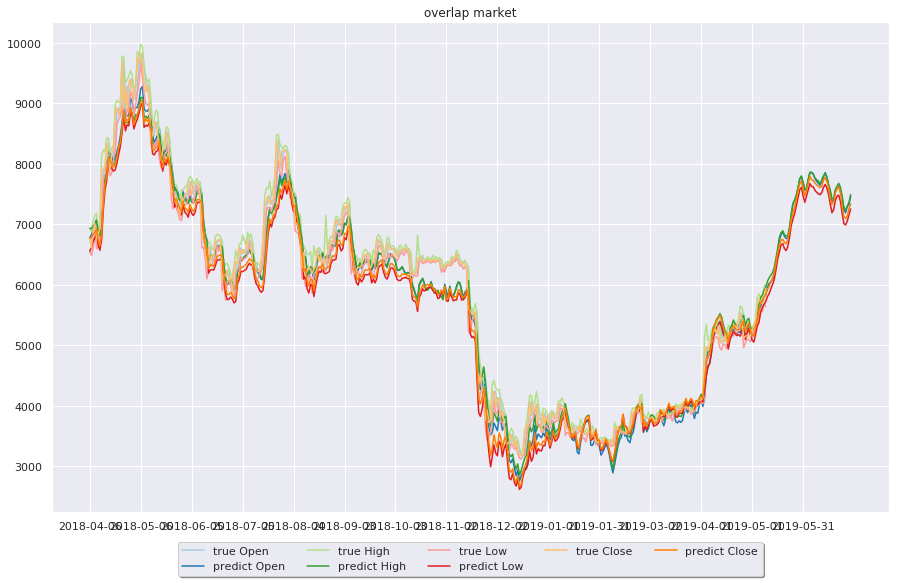

In [0]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5, "open"),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5, "high"),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5, "low"),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5, "close"),
    label = 'predict Close',
    color = current_palette[7],
)

box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

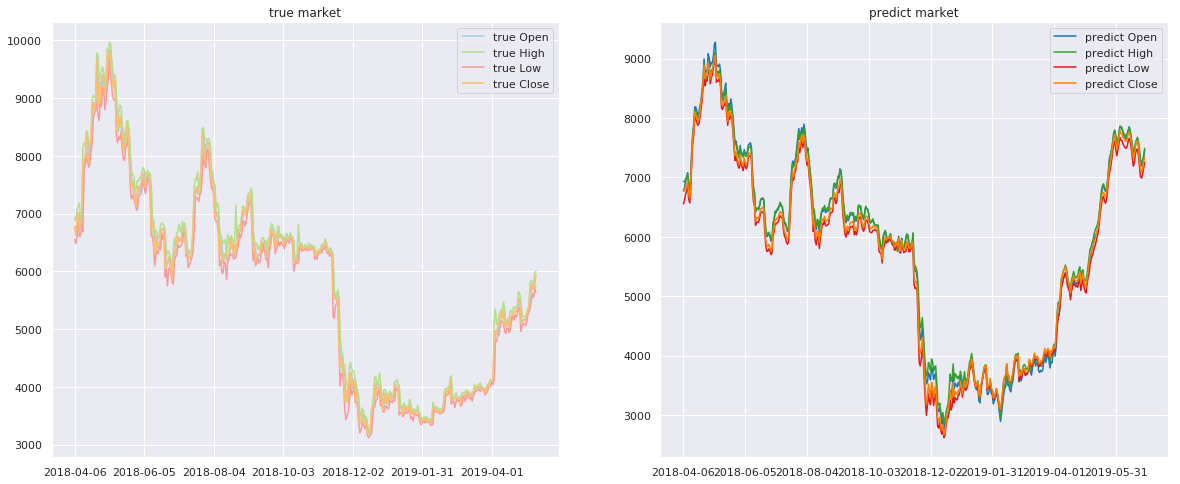

In [0]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)

plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5, "open"),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5, "high"),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5, "low"),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5, "close"),
    label = 'predict Close',
    color = current_palette[7],
)


plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

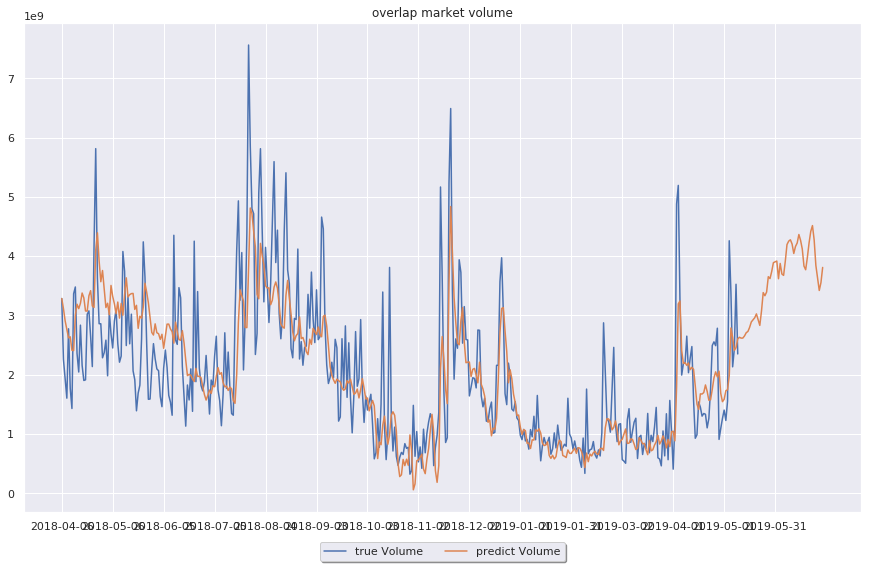

In [0]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5, "volume"), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

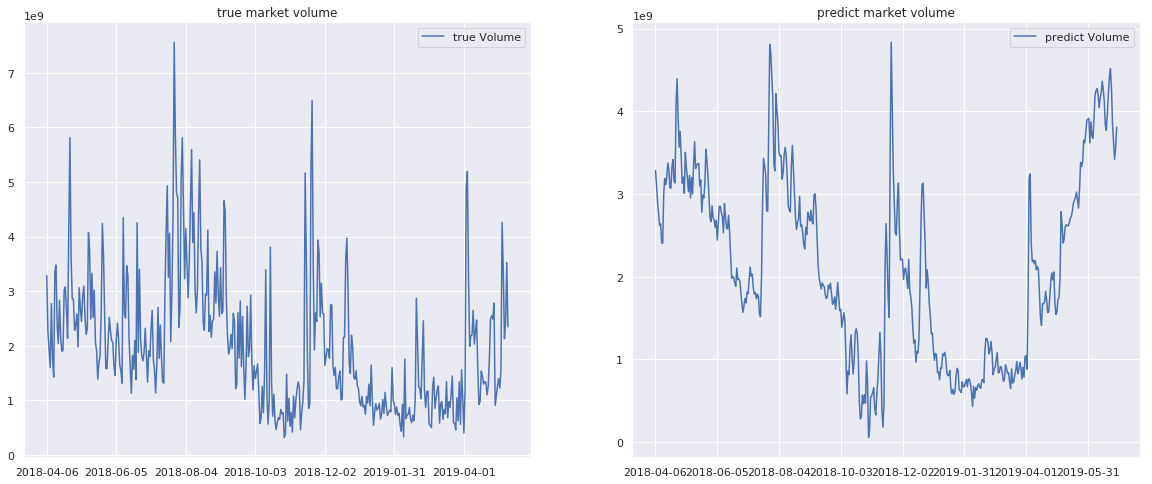

In [0]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5, "volume"), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()

In [0]:
from pprint import pprint
pprint(vectorz)

{'close': [6769.5,
           6778.002596825361,
           6841.406283095479,
           6861.065020747483,
           6931.542659152299,
           6730.847876125947,
           6653.364718851633,
           6832.043497948442,
           7343.200539483922,
           7672.300468451926,
           7799.119673404668,
           8102.451830016362,
           8042.901706659191,
           7998.093756568131,
           7948.055282866804,
           7968.083812060877,
           8097.953396262191,
           8271.7463115759,
           8359.947531417376,
           8583.224984638575,
           8890.362757142724,
           8663.564353032083,
           8730.18886177896,
           8713.901932414166,
           8928.435503957566,
           8819.010166748314,
           8646.320299334302,
           8738.249689001328,
           8814.125878671053,
           8891.946758826198,
           9017.665078858347,
           9051.205709730491,
           8669.641121732646,
           8745.37551687